In [1]:
import sys, os, re, json
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from collections import defaultdict, Counter
from typing import List, Tuple, Dict

In [2]:
%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Redux
[nltk_data]     Gamer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Redux
[nltk_data]     Gamer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Redux
[nltk_data]     Gamer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
file_business = "yelp_academic_dataset_business.json"
file_review = "yelp_academic_dataset_review.json"

In [4]:
def get_restaurants(file_business):
    with open(file_business, 'r',encoding='utf-8') as file:
        restaurants = set()

        for json_str in file:
            obj = json.loads(json_str)
            if obj["business_id"] and obj["categories"] \
            and "restaurants" in obj["categories"].lower():
                restaurants.add(obj["business_id"])

    return restaurants

In [5]:
%time restaurants = get_restaurants(file_business)

CPU times: total: 1.23 s
Wall time: 1.46 s


In [6]:
print("Number of restaurants:", len(restaurants))

Number of restaurants: 52268


In [7]:
def get_reviews(file_review):
    with open(file_review, 'r',encoding='utf-8') as file:
        text_list = []
        stars_list = []

        for index, json_str in enumerate(file):
            obj = json.loads(json_str)
            if obj["business_id"] and obj["business_id"] in restaurants:
                if obj["text"] and obj["stars"]:
                    text_list.append(obj["text"])
                    stars_list.append(int(obj["stars"]))

    df = pd.DataFrame.from_dict({"text": text_list, "stars": stars_list})
    return df

In [8]:
%time df_review = get_reviews(file_review)

CPU times: total: 45.5 s
Wall time: 46.6 s


In [11]:
df_review = df_review.sample(500000)

In [12]:
df_review["stars"].value_counts(normalize=False)

5    220023
4    119591
1     60195
3     57349
2     42842
Name: stars, dtype: int64

In [13]:
def plot_labels(df, title=None):
    ds_labels = df["stars"].value_counts(normalize=True)
    ds_labels.sort_index(inplace=True)
    plt.figure(figsize=(4,3))
    ax = ds_labels.plot(kind="bar")
    ax.set_xlabel("Stars")
    ax.set_ylabel("Ratio")
    if title is not None:
        plt.savefig(title + ".eps")
    plt.show()

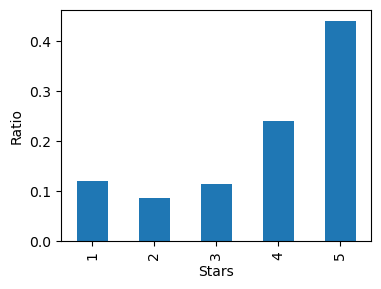

In [14]:
plot_labels(df_review, "stars")

In [15]:
from sklearn.model_selection import train_test_split

df_train_raw, df_test = train_test_split(df_review, test_size=5000, 
                                         random_state=42, shuffle=True)
df_train_raw, df_dev = train_test_split(df_train_raw, test_size=5000,
                                        random_state=42, shuffle=True)

In [17]:
from sklearn.utils import resample

def undersample(df, group_size=5000):
    dfs = []

    for label in df["stars"].value_counts().keys():
        df_group = df[df["stars"] == label]
        df_group_undersampled = resample(df_group, 
                                     replace=False, 
                                     n_samples=group_size, 
                                     random_state=0)
        dfs.append(df_group_undersampled)

    return pd.concat(dfs).sample(frac=1, random_state=0)

In [18]:
df_train = undersample(df_train_raw)

In [19]:
num_review = df_review.shape[0]
num_train = df_train.shape[0]
num_dev = df_dev.shape[0]
num_test = df_test.shape[0]

(25000, 2)


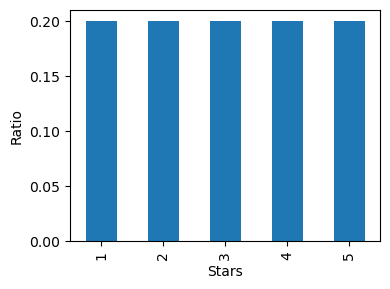

In [20]:
print(df_train.shape)
plot_labels(df_train)

(5000, 2)


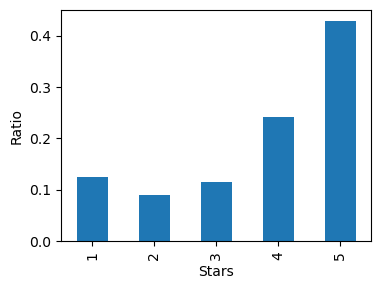

In [21]:
print(df_dev.shape)
plot_labels(df_dev)

(5000, 2)


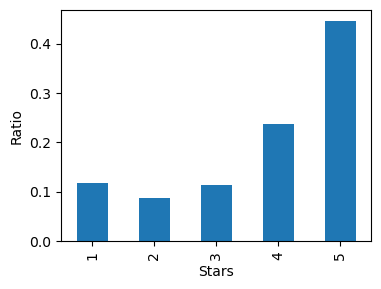

In [22]:
print(df_test.shape)
plot_labels(df_test)

In [23]:
df_train["labels"] = df_train["stars"] - 1
df_dev["labels"] = df_dev["stars"] - 1
df_test["labels"] = df_test["stars"] - 1

In [25]:
from nltk.tokenize import word_tokenize

In [ ]:
ds_temp = df_train["text"].iloc[:10].map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).map(lambda text: text.split())

In [27]:
%time df_train["tokens"] = df_train["text"].map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).map(lambda text: text.split())

CPU times: total: 359 ms
Wall time: 400 ms


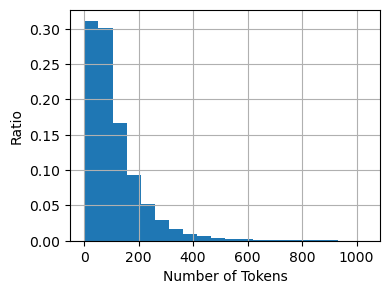

In [28]:
df_train["num_tokens"] = df_train["tokens"].map(len)
ax = df_train["num_tokens"].hist(bins=20, 
                                 figsize=(4,3),
                                 weights=np.ones(num_train)/num_train)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.show()

In [29]:
%%time
print(len(df_train[df_train["num_tokens"] <= 128]) / len(df_train["num_tokens"]))
print(len(df_train[df_train["num_tokens"] <= 256]) / len(df_train["num_tokens"]))

0.7026
0.92228
CPU times: total: 15.6 ms
Wall time: 8.01 ms


In [30]:
df_train.drop(columns=["tokens", "num_tokens"], inplace=True)

In [31]:
%time df_review["num_tokens"] = df_review["text"].\
map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).\
map(lambda text: len(text.split()))

CPU times: total: 5.92 s
Wall time: 6.06 s


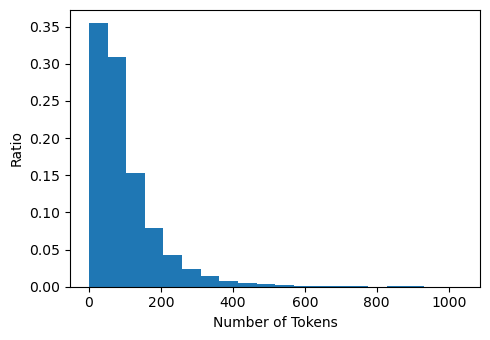

In [32]:
ax = df_review["num_tokens"].hist(bins=20,
                                  figsize=(5,3.5),
                                  grid=False,
                                  weights=np.ones(num_review)/num_review)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.savefig("num_tokens.eps")
plt.tight_layout()
plt.show()

In [33]:
print(len(df_review[df_review["num_tokens"] <= 128]) / len(df_review["num_tokens"]))
print(len(df_review[df_review["num_tokens"] <= 256]) / len(df_review["num_tokens"]))

0.750244
0.937732


In [34]:
df_review.drop(columns=["num_tokens"], inplace=True)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def extract_features(df_train, df_dev, df_test):
    vectorizer = TfidfVectorizer(analyzer='word', 
                                 stop_words='english',
                                 ngram_range=(1, 2),
                                 lowercase=True,
                                 min_df=5,
                                 binary=False)
    X_train = vectorizer.fit_transform(df_train["text"])
    X_dev = vectorizer.transform(df_dev["text"])
    X_test = vectorizer.transform(df_test["text"])
    y_train = df_train["stars"].tolist()
    y_dev = df_dev["stars"].tolist()
    y_test = df_test["stars"].tolist()
  
    return X_train, X_dev, X_test, y_train, y_dev, y_test

In [36]:
%time X_train, X_dev, X_test, y_train, y_dev, y_test = extract_features(df_train, df_dev, df_test)

CPU times: total: 4.19 s
Wall time: 4.33 s


In [37]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [38]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.5s finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=0,
                   verbose=1)

In [39]:
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
    if y_pred is None:
        y_pred = model.predict(X)

    print(label + ' Set')
    print("Accuracy:", accuracy_score(y, y_pred))
    print()

    print(classification_report(y, y_pred, digits=4))

    print()
    

def evaluate_model(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
    evaluate_model_Xy(model, X_dev, y_dev, label="Validation", model_name=model_name)
    evaluate_model_Xy(model, X_test, y_test, label="Testing", model_name=model_name)

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report

In [41]:
#evaluate_model(clf_lr,  model_name="lr_count_bin")
evaluate_model(clf_lr, model_name="lr")

Validation Set
Accuracy: 0.585

              precision    recall  f1-score   support

           1     0.6822    0.6811    0.6816       624
           2     0.3758    0.4989    0.4287       449
           3     0.3661    0.4278    0.3945       575
           4     0.4517    0.4615    0.4566      1207
           5     0.7852    0.6867    0.7327      2145

    accuracy                         0.5850      5000
   macro avg     0.5322    0.5512    0.5388      5000
weighted avg     0.6069    0.5850    0.5935      5000


Testing Set
Accuracy: 0.595

              precision    recall  f1-score   support

           1     0.6622    0.6746    0.6684       587
           2     0.3668    0.4896    0.4194       433
           3     0.3834    0.4647    0.4201       566
           4     0.4560    0.4721    0.4639      1184
           5     0.8081    0.6928    0.7460      2230

    accuracy                         0.5950      5000
   macro avg     0.5353    0.5588    0.5436      5000
weighted avg   

In [42]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [43]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=0,
                   verbose=1)

In [44]:
evaluate_model(clf_lr, model_name="lr_count_int")

Validation Set
Accuracy: 0.585

              precision    recall  f1-score   support

           1     0.6822    0.6811    0.6816       624
           2     0.3758    0.4989    0.4287       449
           3     0.3661    0.4278    0.3945       575
           4     0.4517    0.4615    0.4566      1207
           5     0.7852    0.6867    0.7327      2145

    accuracy                         0.5850      5000
   macro avg     0.5322    0.5512    0.5388      5000
weighted avg     0.6069    0.5850    0.5935      5000


Testing Set
Accuracy: 0.595

              precision    recall  f1-score   support

           1     0.6622    0.6746    0.6684       587
           2     0.3668    0.4896    0.4194       433
           3     0.3834    0.4647    0.4201       566
           4     0.4560    0.4721    0.4639      1184
           5     0.8081    0.6928    0.7460      2230

    accuracy                         0.5950      5000
   macro avg     0.5353    0.5588    0.5436      5000
weighted avg   

In [45]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB(alpha=0.5,
                       fit_prior=True)

In [46]:
%time clf_nb.fit(X_train, y_train)

CPU times: total: 62.5 ms
Wall time: 19 ms


MultinomialNB(alpha=0.5)

In [47]:
evaluate_model(clf_nb, model_name="nb")

Validation Set
Accuracy: 0.5808

              precision    recall  f1-score   support

           1     0.6542    0.6731    0.6635       624
           2     0.3693    0.4878    0.4203       449
           3     0.3707    0.4539    0.4081       575
           4     0.4518    0.4772    0.4641      1207
           5     0.7996    0.6657    0.7265      2145

    accuracy                         0.5808      5000
   macro avg     0.5291    0.5515    0.5365      5000
weighted avg     0.6095    0.5808    0.5912      5000


Testing Set
Accuracy: 0.5976

              precision    recall  f1-score   support

           1     0.6202    0.6899    0.6532       587
           2     0.3685    0.4596    0.4090       433
           3     0.3939    0.4753    0.4307       566
           4     0.4679    0.5101    0.4881      1184
           5     0.8243    0.6776    0.7438      2230

    accuracy                         0.5976      5000
   macro avg     0.5350    0.5625    0.5450      5000
weighted avg 

In [48]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [49]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=0,
                   verbose=1)

In [50]:
evaluate_model(clf_lr, model_name="lr")

Validation Set
Accuracy: 0.585

              precision    recall  f1-score   support

           1     0.6822    0.6811    0.6816       624
           2     0.3758    0.4989    0.4287       449
           3     0.3661    0.4278    0.3945       575
           4     0.4517    0.4615    0.4566      1207
           5     0.7852    0.6867    0.7327      2145

    accuracy                         0.5850      5000
   macro avg     0.5322    0.5512    0.5388      5000
weighted avg     0.6069    0.5850    0.5935      5000


Testing Set
Accuracy: 0.595

              precision    recall  f1-score   support

           1     0.6622    0.6746    0.6684       587
           2     0.3668    0.4896    0.4194       433
           3     0.3834    0.4647    0.4201       566
           4     0.4560    0.4721    0.4639      1184
           5     0.8081    0.6928    0.7460      2230

    accuracy                         0.5950      5000
   macro avg     0.5353    0.5588    0.5436      5000
weighted avg   

In [51]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [52]:
clf_rf.fit(X_train, y_train)

c:\anaconda3\envs\p4k\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.8s finished


RandomForestClassifier(class_weight='balanced', max_features='auto',
                       min_samples_leaf=10, n_estimators=500, n_jobs=-1,
                       random_state=0, verbose=1)

In [53]:
evaluate_model(clf_rf, model_name="rf")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Validation Set
Accuracy: 0.582

              precision    recall  f1-score   support

           1     0.5747    0.7708    0.6585       624
           2     0.3573    0.3318    0.3441       449
           3     0.3646    0.3722    0.3683       575
           4     0.4733    0.3447    0.3988      1207
           5     0.7237    0.7692    0.7458      2145

    accuracy                         0.5820      5000
   macro avg     0.4987    0.5177    0.5031      5000
weighted avg     0.5704    0.5820    0.5716      5000




[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.1s finished


Testing Set
Accuracy: 0.5978

              precision    recall  f1-score   support

           1     0.5369    0.7939    0.6405       587
           2     0.3675    0.3395    0.3529       433
           3     0.3810    0.3905    0.3857       566
           4     0.5108    0.3581    0.4211      1184
           5     0.7455    0.7762    0.7605      2230

    accuracy                         0.5978      5000
   macro avg     0.5083    0.5316    0.5122      5000
weighted avg     0.5914    0.5978    0.5883      5000




In [54]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))

In [55]:
clf_sgd.fit(X_train, y_train)

-- Epoch 1-- Epoch 1
-- Epoch 1

-- Epoch 1
-- Epoch 1
Norm: 0.12, NNZs: 41588, Bias: -0.005242, T: 22500, Avg. loss: 0.540805
Total training time: 0.01 seconds.
Norm: 0.11, NNZs: 41466, Bias: -0.006059, T: 22500, Avg. loss: 0.535256
Total training time: 0.01 seconds.
Norm: 0.11, NNZs: 41627, Bias: 0.002244, T: 22500, Avg. loss: 0.611678
Total training time: 0.01 seconds.
Norm: 0.11, NNZs: 41567, Bias: -0.005366, T: 22500, Avg. loss: 0.588282
Total training time: 0.01 seconds.
Norm: 0.11, NNZs: 41647, Bias: -0.005802, T: 22500, Avg. loss: 0.602495
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 0.11, NNZs: 41535, Bias: -0.006163, T: 45000, Avg. loss: 0.501805
Total training time: 0.02 seconds.
Norm: 0.11, NNZs: 41663, Bias: -0.005920, T: 45000, Avg. loss: 0.564948
Total training time: 0.02 seconds.
Norm: 0.11, NNZs: 41648, Bias: 0.002127, T: 45000, Avg. loss: 0.572262
Total training time: 0.02 seconds.
Norm: 0.11, NNZs: 41618, Bias: -0.00

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier',
                 SGDClassifier(alpha=30, class_weight='balanced',
                               early_stopping=True, n_jobs=-1, random_state=0,
                               verbose=1))])

In [56]:
evaluate_model(clf_sgd, model_name="sgd")

Validation Set
Accuracy: 0.5786

              precision    recall  f1-score   support

           1     0.5566    0.7724    0.6470       624
           2     0.3706    0.3252    0.3464       449
           3     0.3451    0.3391    0.3421       575
           4     0.4587    0.4051    0.4303      1207
           5     0.7496    0.7371    0.7433      2145

    accuracy                         0.5786      5000
   macro avg     0.4961    0.5158    0.5018      5000
weighted avg     0.5748    0.5786    0.5739      5000


Testing Set
Accuracy: 0.6028

              precision    recall  f1-score   support

           1     0.5364    0.8160    0.6473       587
           2     0.3911    0.3233    0.3540       433
           3     0.3930    0.3763    0.3845       566
           4     0.4844    0.4316    0.4565      1184
           5     0.7765    0.7493    0.7627      2230

    accuracy                         0.6028      5000
   macro avg     0.5163    0.5393    0.5210      5000
weighted avg 

In [57]:
%pip install simpletransformers
from simpletransformers.classification import ClassificationModel

Note: you may need to restart the kernel to use updated packages.


c:\anaconda3\envs\p4k\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [59]:
def evaluate_bert_model_one(model, df, label="Training", model_name="model"):
    y = df['labels'].tolist()
    y_pred, raw_outputs = model.predict(df['text'].tolist())

    print(label + ' Set')
    print("Accuracy:", accuracy_score(y, y_pred))
    print()

    print(classification_report(y, y_pred, digits=4))
    df_cm = pd.DataFrame(confusion_matrix(y, y_pred, normalize='true'), 
                       range(1,6), range(1,6))
    plt.figure(figsize=(6,4))
    ax = sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, square=True)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    plt.savefig(model_name + "_" + label.lower() + ".eps")
    plt.show()
    print()

In [60]:
def evaluate_bert_model(model, model_name="model"):
    evaluate_bert_model_one(model, df_dev, label="Validation", model_name=model_name)
    evaluate_bert_model_one(model, df_test, label="Testing", model_name=model_name)
    # evaluate_bert_model_one(model, df_train, label="Training", model_name=model_name)

In [61]:
model_bert_base_cased_64 = \
ClassificationModel('bert',
                    'bert-base-cased',
                    num_labels=5,
                    args={"output_dir": "outputs_bert_base_cased_64/",
                          "best_model_dir": "outputs_bert_base_cased_64/best_model/",
                          "max_seq_length": 64,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [62]:
model_bert_base_cased_64.train_model(df_train)

Epochs 0/1. Running Loss:    1.4500:   4%|█▊                                         | 65/1563 [00:11<02:29, 10.00it/s]


Epochs 0/1. Running Loss:    1.4576:   8%|███▌                                      | 131/1563 [00:17<02:24,  9.93it/s]


Epochs 0/1. Running Loss:    1.0881:  13%|█████▎                                    | 197/1563 [00:24<02:25,  9.37it/s]


Epochs 0/1. Running Loss:    1.2698:  17%|███████                                   | 263/1563 [00:32<02:26,  8.88it/s]


Epochs 0/1. Running Loss:    1.1357:  21%|████████▊                                 | 329/1563 [00:39<02:13,  9.24it/s]


Epochs 0/1. Running Loss:    1.2772:  25%|██████████▌                               | 395/1563 [00:46<01:50, 10.61it/s]


Epochs 0/1. Running Loss:    1.2493:  29%|████████████▍                             | 461/1563 [00:53<01:55,  9.55it/s]


Epochs 0/1. Running Loss:    1.2174:  34%|██████████████▏                           | 527/1563 [01:00<02:00,  8.57it/s]


Epochs 0/1. Running Loss:    1.0184:  38%|███████████████▉                          | 593/1563 [01:07<01:46,  9.10it/s]


Epochs 0/1. Running Loss:    0.8940:  42%|█████████████████▋                        | 659/1563 [01:15<01:36,  9.36it/s]


Epochs 0/1. Running Loss:    1.1679:  46%|███████████████████▍                      | 725/1563 [01:22<01:33,  8.98it/s]


Epochs 0/1. Running Loss:    0.9970:  51%|█████████████████████▎                    | 791/1563 [01:30<01:26,  8.95it/s]


Epochs 0/1. Running Loss:    1.0410:  55%|███████████████████████                   | 857/1563 [01:37<01:19,  8.84it/s]


Epochs 0/1. Running Loss:    1.1341:  59%|████████████████████████▊                 | 923/1563 [01:43<01:00, 10.63it/s]


Epochs 0/1. Running Loss:    1.3243:  63%|██████████████████████████▌               | 989/1563 [01:50<00:53, 10.64it/s]


Epochs 0/1. Running Loss:    1.2716:  67%|███████████████████████████▋             | 1055/1563 [01:56<00:47, 10.61it/s]


Epochs 0/1. Running Loss:    0.8432:  72%|█████████████████████████████▍           | 1121/1563 [02:02<00:41, 10.64it/s]


Epochs 0/1. Running Loss:    0.8841:  76%|███████████████████████████████▏         | 1187/1563 [02:08<00:35, 10.63it/s]


Epochs 0/1. Running Loss:    0.7023:  80%|████████████████████████████████▊        | 1253/1563 [02:14<00:29, 10.59it/s]


Epochs 0/1. Running Loss:    0.9736:  84%|██████████████████████████████████▌      | 1319/1563 [02:21<00:22, 10.72it/s]


Epochs 0/1. Running Loss:    0.9823:  89%|████████████████████████████████████▎    | 1385/1563 [02:27<00:16, 10.62it/s]


Epochs 0/1. Running Loss:    0.9286:  93%|██████████████████████████████████████   | 1451/1563 [02:33<00:10, 10.60it/s]


Epochs 0/1. Running Loss:    1.1036:  97%|███████████████████████████████████████▊ | 1517/1563 [02:39<00:04, 10.55it/s]


Epoch 1 of 1: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [02:44<00:00, 164.02s/it]


(1563, 1.0863949714070014)

100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:08<00:00, 77.33it/s]


Validation Set
Accuracy: 0.6036

              precision    recall  f1-score   support

           0     0.7208    0.6619    0.6901       624
           1     0.3729    0.5033    0.4284       449
           2     0.3913    0.4696    0.4269       575
           3     0.4751    0.4499    0.4621      1207
           4     0.7877    0.7301    0.7578      2145

    accuracy                         0.6036      5000
   macro avg     0.5496    0.5629    0.5531      5000
weighted avg     0.6211    0.6036    0.6103      5000



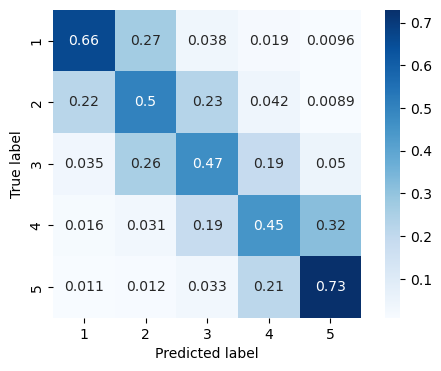

100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:09<00:00, 66.87it/s]


Testing Set
Accuracy: 0.6092

              precision    recall  f1-score   support

           0     0.6966    0.6337    0.6637       587
           1     0.3589    0.4965    0.4167       433
           2     0.3961    0.5088    0.4455       566
           3     0.4801    0.4797    0.4799      1184
           4     0.8191    0.7188    0.7657      2230

    accuracy                         0.6092      5000
   macro avg     0.5502    0.5675    0.5543      5000
weighted avg     0.6367    0.6092    0.6196      5000



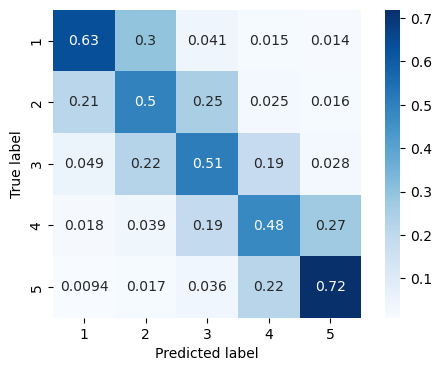

In [63]:
evaluate_bert_model(model_bert_base_cased_64, model_name="bert_base_cased_64")

In [64]:
del model_bert_base_cased_64